In [30]:
import os
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.io import ascii
from astropy.table import Table, join, hstack, vstack
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from astropy.io import fits
from thejoker.data import RVData
import pandas as pd

import pystan

In [2]:
os.makedirs('calibrate-visit-err', exist_ok=True)

In [3]:
sm = pystan.StanModel('visit-err.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f025c2285e2ea9e6177ef1ff68c8a615 NOW.


In [4]:
allstar = fits.getdata('../data/allStarLite-r12-l33.fits')

In [5]:
allstar_c = coord.SkyCoord(allstar['RA'], allstar['DEC'], unit=u.deg)

In [6]:
allvisit = fits.getdata('../data/allVisit-r12-l33.fits')

---

In [132]:
from scipy.optimize import minimize

In [133]:
def func(p, yn, sign):
    mu, a, lns = p
    s = np.exp(lns)
    var = (a*sign)**2 + s**2
    
    # negative log-likelhiood
    return np.sum((yn - mu)**2 / var + np.log(var))

In [90]:
mask = ((allstar['NVISITS'] > 5) 
        & (allstar['TEFF'] < 5500)
        & (allstar['LOGG'] > 2)
        & (allstar['LOGG'] < 2.5))
mask.sum()

10007

In [187]:
res = minimize(func, x0=[mu, 1., -3.], 
               args=(visits['VHELIO'], visits['VRELERR']), 
               bounds=[(-250, 250), (0.1, 10), (-5, 3)],
               method='L-BFGS-B',
               options=dict(epsilon=1e-3))

res

/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:5: OptimizeWarning: Unknown solver options: epsilon
  """


      fun: 48.070587
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
   status: 0
  success: True
        x: array([106.66400146,   1.        ,  -3.        ])

In [162]:
a_vals = []
s_vals = []
for i in trange(100):
    apid = allstar[mask]['APOGEE_ID'][i]
    mu = allstar[mask]['VHELIO_AVG'][i]
    visits = allvisit[allvisit['APOGEE_ID'] == apid]
    
#     res = minimize(func, x0=[mu, 1., -3.], 
#                    args=(visits['VHELIO'], visits['VRELERR']), 
#                    bounds=[(-250, 250), (0.1, 10), (-5, 3)])
    res = minimize(func, x0=[mu, 1., -3.], 
                   args=(visits['VHELIO'], visits['VRELERR']), 
                   method='powell')
    
    if not res.success:
        break
    
    a_vals.append(res.x[1])
    s_vals.append(res.x[2])
    
a_vals = np.array(a_vals)
s_vals = np.array(s_vals)




  0%|          | 0/100 [00:00<?, ?it/s]


  1%|          | 1/100 [00:00<00:44,  2.23it/s]


  2%|▏         | 2/100 [00:00<00:41,  2.39it/s]


  3%|▎         | 3/100 [00:01<00:38,  2.53it/s]


  4%|▍         | 4/100 [00:01<00:36,  2.62it/s]


  5%|▌         | 5/100 [00:01<00:34,  2.72it/s]


  6%|▌         | 6/100 [00:02<00:33,  2.82it/s]


  7%|▋         | 7/100 [00:02<00:32,  2.88it/s]


  8%|▊         | 8/100 [00:02<00:31,  2.97it/s]


  9%|▉         | 9/100 [00:03<00:30,  2.99it/s]


 10%|█         | 10/100 [00:03<00:29,  3.06it/s]


 11%|█         | 11/100 [00:03<00:28,  3.07it/s]


 12%|█▏        | 12/100 [00:04<00:31,  2.80it/s]


 13%|█▎        | 13/100 [00:04<00:30,  2.85it/s]


 14%|█▍        | 14/100 [00:04<00:30,  2.86it/s]


 15%|█▌        | 15/100 [00:05<00:29,  2.89it/s]


 16%|█▌        | 16/100 [00:05<00:28,  2.94it/s]


 17%|█▋        | 17/100 [00:05<00:27,  2.97it/s]


 18%|█▊        | 18/100 [00:06<00:27,  2.99it/s]


 19%|█▉        | 19/100 [00:06<00:26,  3.00it/

(-1, 3)

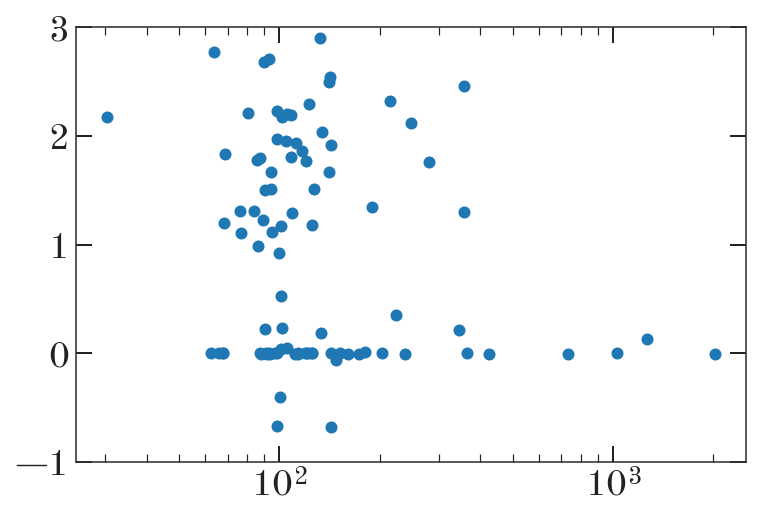

In [166]:
plt.scatter(allstar[mask]['SNR'][:100], a_vals)
plt.xscale('log')
plt.ylim(-1, 3)

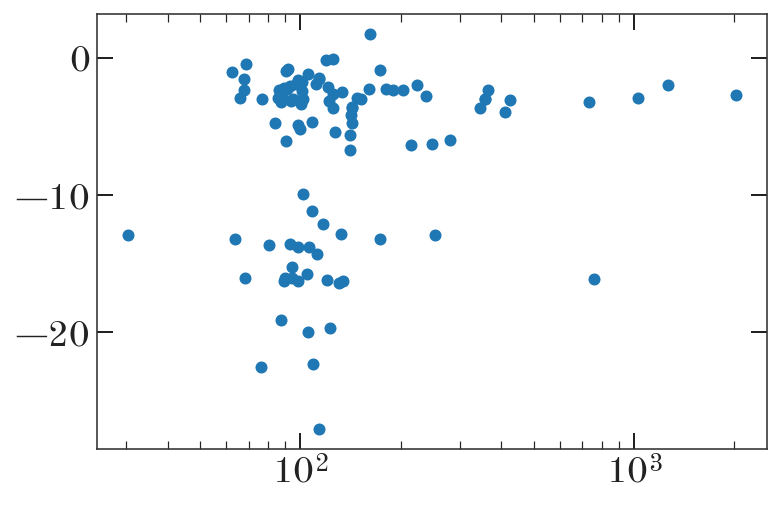

In [164]:
plt.scatter(allstar[mask]['SNR'][:100], s_vals)
plt.xscale('log')

(0.001, 100.0)

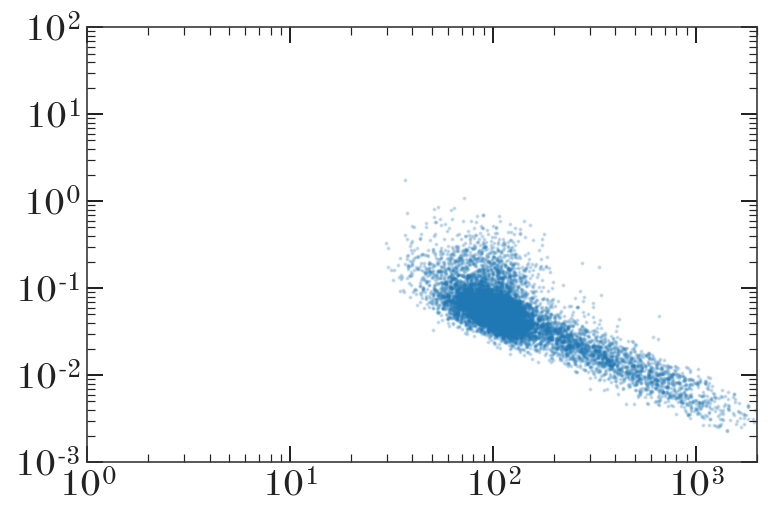

In [181]:
plt.scatter(allstar['SNR'][mask], 
            allstar['VERR_MED'][mask], 
            s=1, alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 2e3)
plt.ylim(1e-3, 1e2)

In [117]:
fns = []
vals = np.linspace(-10, 1, 128)
for val in vals:
    fns.append(func(val, visits['VHELIO'], visits['VRELERR'], mu))

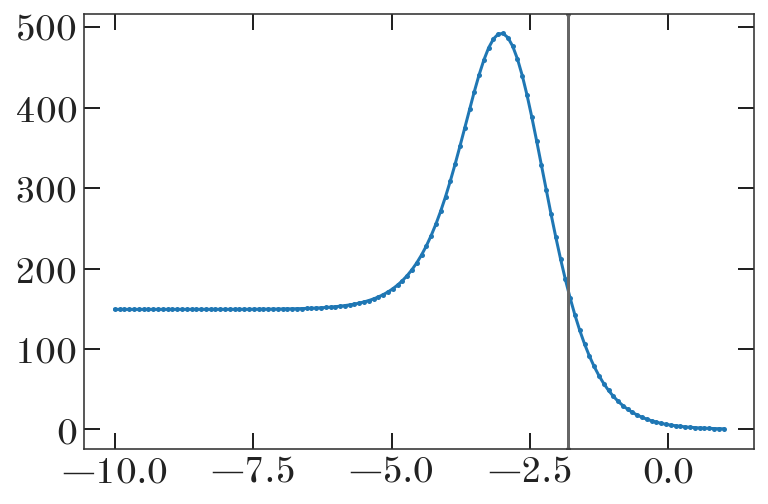

In [120]:
plt.plot(vals, fns)
plt.axvline(np.log(np.std(visits['VHELIO'])) + 1)

In [121]:
res = root(func, x0=np.log(np.std(visits['VHELIO'])) + 1, 
               args=(visits['VHELIO'], visits['VRELERR'], mu), 
               options=dict(factor=1e-2))

res

    fjac: array([[-1.]])
     fun: 2.924935374574878e-117
 message: 'The number of calls to function has reached maxfev = 400.'
    nfev: 400
     qtf: array([-5.84987075e-117])
       r: array([1.6879159e-116])
  status: 2
 success: False
       x: array([135.06047148])

--- 

In [32]:
from hq.config import Config

In [33]:
c = Config.from_run_name('dr16')
allstar, allvisit = c.load_alldata()

In [34]:
df = pd.DataFrame()
df['APOGEE_ID'] = allvisit['APOGEE_ID']
df['SNR'] = allvisit['SNR']
df['VHELIO'] = allvisit['VHELIO']
df['VRELERR'] = allvisit['VRELERR']

In [36]:
def apwstd(x):
    ivar = 1 / x['VRELERR']**2
    return np.sum(x['VHELIO'] * ivar) / np.sum(ivar)

derp = df.groupby('APOGEE_ID').agg(apwstd)

/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in float_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


(0.001, 10)

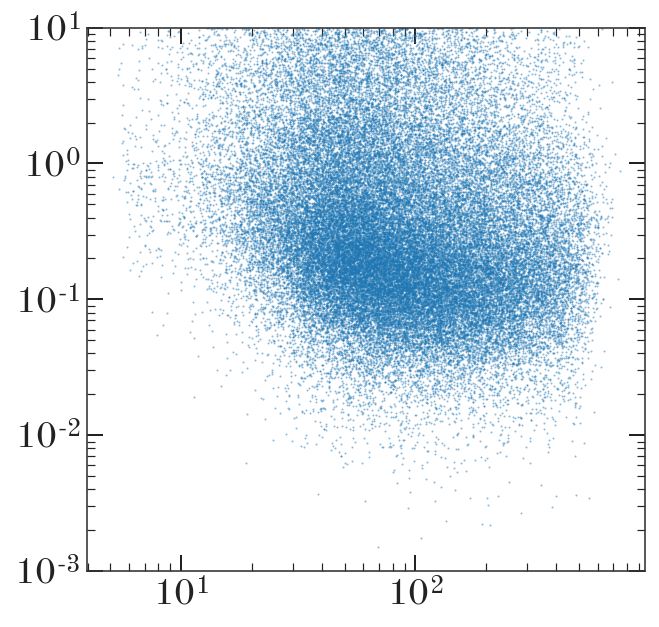

In [50]:
g = df.groupby('APOGEE_ID')

plt.figure(figsize=(5, 5))
plt.plot(g['SNR'].median(), 
         np.sqrt(g['VHELIO'].std()**2 - (0.072 + 2.5*g['VRELERR'].mean())**2), 
         marker='o', ls='none', ms=1., alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3, 10)

## Load exoplanet validation sample:

In [7]:
exop = Table.read('../data/exoplanets_notbinaries.votable')
total_pm = np.sqrt(exop['gaia_pmra']**2 + exop['gaia_pmdec']**2)
slow_exo_mask = ((15*total_pm * u.mas).to(u.arcsec) < 5*u.arcsec)
exop = exop[slow_exo_mask]

In [8]:
exo_c = coord.SkyCoord(ra=exop['ra'], dec=exop['dec'])

In [9]:
idx, sep, _ = exo_c.match_to_catalog_sky(allstar_c)

sub_exop = exop[sep < 8*u.arcsec]['pl_hostname', 'pl_rvamp', 'pl_rvamperr1', 'pl_rvamperr2', 
                                  'hd_name', 'hip_name', 'st_j', 'st_h', 'pl_orbper', 'pl_bmassj']
apogee_exo = hstack((Table(allstar[idx[sep < 8*u.arcsec]]), sub_exop))
hmask = (np.abs(apogee_exo['H'] - apogee_exo['st_h']) < 1e-2)
apogee_exo = apogee_exo[hmask & (apogee_exo['NVISITS'] >= 4) & (apogee_exo['pl_rvamp'] < 50.)]
len(apogee_exo)

13

## Load Gaia RV standards validation sample:

In [10]:
rvs = Table.read(path.expanduser('~/data/GaiaDR2/gaia_dr2_rvs_standards.fit'))
rvs['APOGEE_ID'] = ['2M'+x[6:] for x in rvs['_2MASS']]
rvs = rvs[(rvs['e_RV'] < 0.05) & (rvs['s_RV'] < 0.05)]

In [11]:
mask = np.isin(allstar['APOGEE_ID'], rvs['APOGEE_ID'])

In [12]:
sub_allstar = Table(allstar[mask])

In [13]:
join_tbl = join(sub_allstar, rvs, keys='APOGEE_ID')
join_tbl = join_tbl[join_tbl['NVISITS'] >= 4]
len(join_tbl)

21

---

## Combine the two validation samples:

In [14]:
valid_tbl = vstack((join_tbl, apogee_exo))

In [15]:
visit_mask = np.isin(allvisit['APOGEE_ID'], valid_tbl['APOGEE_ID'])
visits = allvisit[visit_mask]

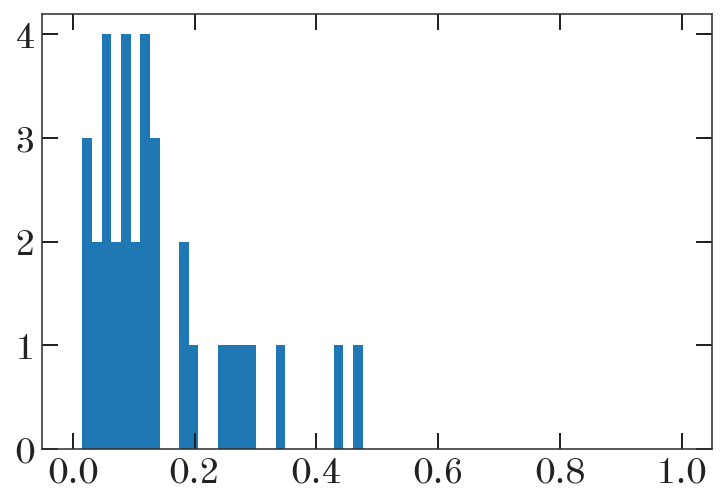

In [16]:
plt.hist(valid_tbl['VSCATTER'], bins=np.linspace(0, 1, 64));

In [17]:
_, all_nvisits, idx = np.unique(visits['APOGEE_ID'], 
                                return_counts=True, return_index=True)

In [18]:
apogee_ids = np.unique(valid_tbl['APOGEE_ID'])
n_stars = len(apogee_ids)
print(n_stars)

all_nvisits = []
rv = []
rv_var = []
rv_snr = []
mean_rv = []
for id_ in apogee_ids:
    this_visits = visits[(visits['APOGEE_ID'] == id_) & np.isfinite(visits['VHELIO'])]
    all_nvisits.append(len(this_visits))
    
    rv.append(this_visits['VHELIO'])
    rv_var.append(this_visits['VRELERR'] ** 2)
    rv_snr.append(this_visits['SNR'])
    mean_rv.append(np.median(this_visits['VHELIO']))
    
rv = np.concatenate(rv)
rv_var = np.concatenate(rv_var)
rv_snr = np.concatenate(rv_snr)

32


In [19]:
data = dict()

data['n_stars'] = n_stars
data['n_visits'] = all_nvisits
data['total_n_visits'] = np.sum(all_nvisits)

data['rv'] = rv
data['rv_var'] = rv_var
data['rv_snr'] = rv_snr

In [20]:
init = dict()

init['mean_rv'] = mean_rv
init['a'] = 1.
init['b'] = -0.5
init['lns'] = -2.

In [21]:
fit = sm.optimizing(data=data, init=init, iter=1024)

In [22]:
fit

OrderedDict([('mean_rv',
              array([ 26.40000558,  45.16139509,  82.64278231,  63.10032531,
                      34.03201785,  33.92539292,  34.00429639,  33.84819727,
                      34.4506301 ,   0.47704048,  -5.48910875,  -1.88916743,
                      -8.7583287 , -32.67383858, -18.03606761, -77.15857533,
                     -11.53584388, -30.58292024, -31.21949975,  -8.17614106,
                     -39.87162985, -70.53214428, -21.67954085, -12.27072421,
                     -28.14049727,   8.10912103, -60.90907654,  27.68220374,
                     -15.91760916, -18.41242861, -25.83667869,   4.30703212])),
             ('a', array(94650.92442511)),
             ('b', array(-4.96112712)),
             ('lns', array(-1.76836891)),
             ('s', array(0.17061104))])

In [23]:
def get_inflation_factor(fit, snr):
    # return fit['a'] + fit['b'] * snr + fit['c'] * snr**2
    # return fit['a'] * snr**fit['b']
    return fit['a'] * snr**fit['b'] + fit['c'] * snr**fit['d']

def get_new_err(fit, visits):
    err = visits['VRELERR']
    snr = visits['SNR']
    return np.sqrt(fit['s']**2 + err**2 + fit['a']*snr**fit['b'])

def get_nidever_err(visits):
    err = visits['VRELERR']
    var = (3.5*err**1.2)**2 + 0.072**2
    return np.sqrt(var)

In [24]:
# snr = np.linspace(1, 500, 1024)
# plt.plot(snr, np.sqrt(get_inflation_factor(fit, snr)))
# plt.xlim(0, 500)
# plt.ylim(0, 10)

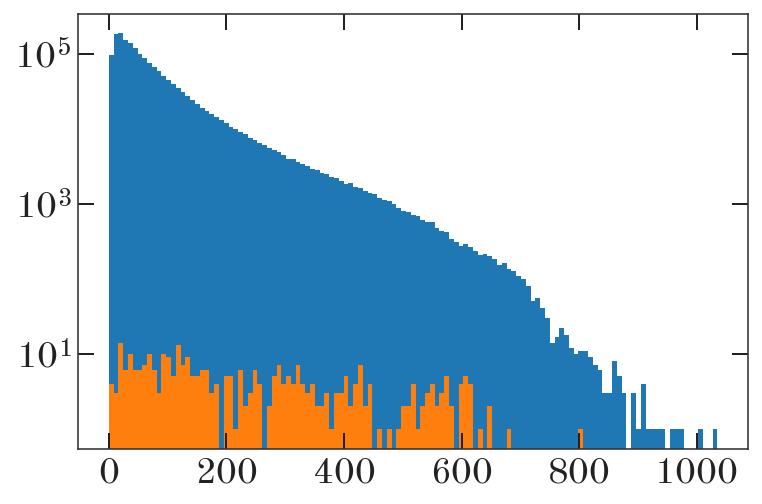

In [25]:
_, bins, _ = plt.hist(allvisit['SNR'][np.isfinite(allvisit['SNR'])], 
                      bins=np.linspace(0, 1035, 128));
plt.hist(visits['SNR'], bins=bins)
plt.yscale('log')

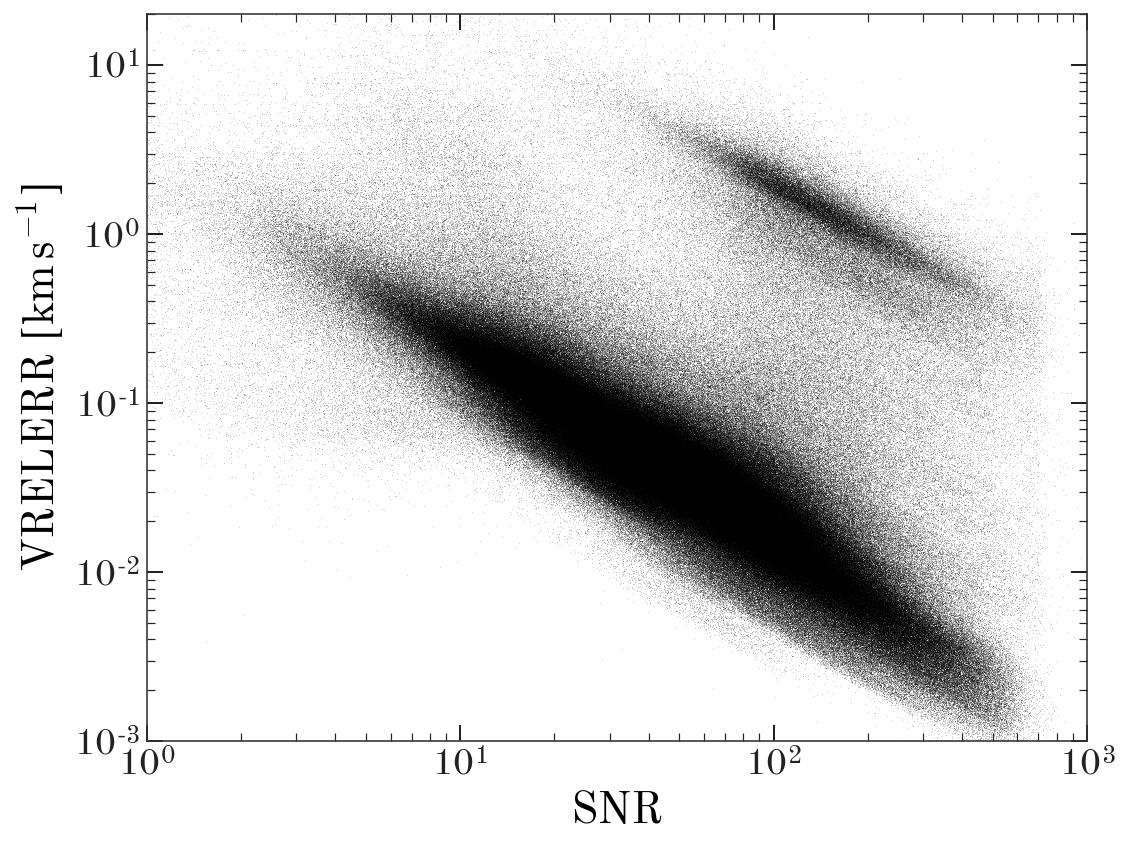

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(allvisit['SNR'], allvisit['VRELERR'], 
        marker=',', color='k', alpha=0.2, ls='none',
        rasterized=True)
fig.tight_layout()
ax.set_xlim(1e0, 1e3)
ax.set_ylim(1e-3, 2e1)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('SNR')
ax.set_ylabel('VRELERR [{:latex_inline}]'.format(u.km/u.s))

fig.tight_layout()

fig.savefig('calibrate-visit-err/calib-err-snr.pdf', dpi=250)

/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


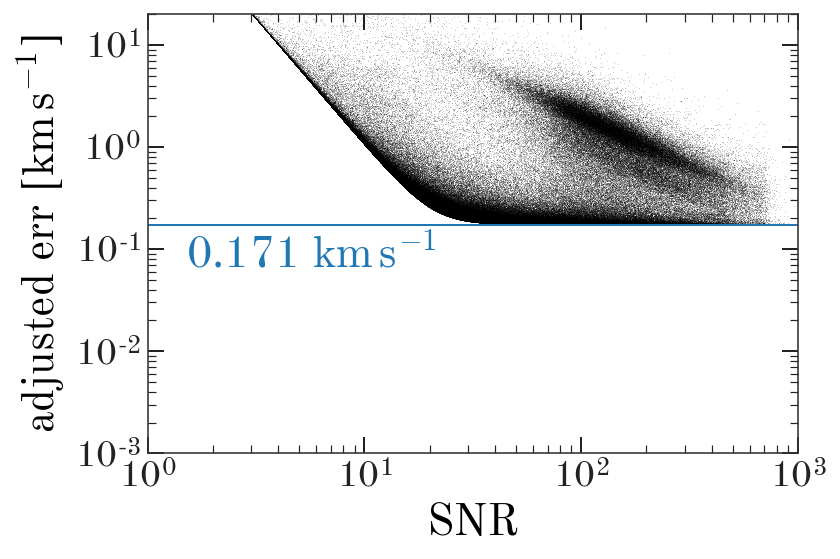

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

new_err = get_new_err(fit, allvisit)
ax.plot(allvisit['SNR'], new_err, 
        marker=',', color='k', alpha=0.2, ls='none',
        rasterized=True)
fig.tight_layout()

ax.set_xlim(1e0, 1e3)
ax.set_ylim(1e-3, 2e1)

ax.set_xscale('log')
ax.set_yscale('log')

ax.axhline(fit['s'], color='tab:blue', marker='', lw=1)
ax.text(1.5, 0.8*fit['s'], '{:.3f} {:latex_inline}'.format(fit['s'], u.km/u.s), 
        va='top', color='tab:blue', fontsize=22)

ax.set_xlabel('SNR')
ax.set_ylabel('adjusted err [{:latex_inline}]'.format(u.km/u.s))

fig.tight_layout()

fig.savefig('calibrate-visit-err/calib-adj-err-snr.pdf', dpi=250)

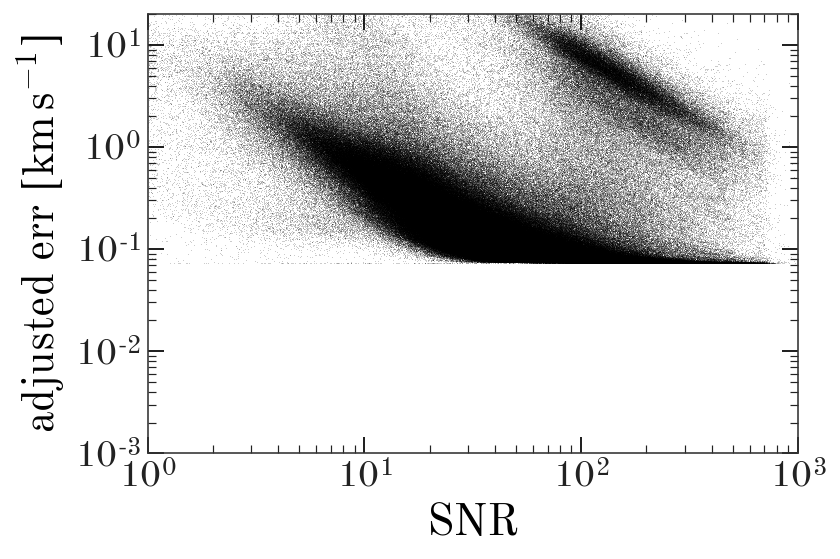

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

nid_err = get_nidever_err(allvisit)
ax.plot(allvisit['SNR'], nid_err, 
        marker=',', color='k', alpha=0.2, ls='none',
        rasterized=True)
fig.tight_layout()

ax.set_xlim(1e0, 1e3)
ax.set_ylim(1e-3, 2e1)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('SNR')
ax.set_ylabel('adjusted err [{:latex_inline}]'.format(u.km/u.s))

fig.tight_layout()

fig.savefig('calibrate-visit-err/nidever-adj-err.pdf', dpi=250)

---

In [ ]:
for id_ in apogee_ids[20:]:
    this_visits = visits[(visits['APOGEE_ID'] == id_) & np.isfinite(visits['VHELIO'])]
    
    snr = this_visits['SNR']
    infl_err = get_new_err(fit, this_visits)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.errorbar(snr, this_visits['VHELIO'], infl_err,
                marker='', ecolor='#aaaaaa', zorder=-100, ls='none')
    ax.plot(snr, this_visits['VHELIO'],
            marker='o', ls='none', color='k')